In [54]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, 
                            confusion_matrix, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve,
                            mean_squared_error, mean_absolute_error, r2_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import mysql.connector
import time
from sklearn.model_selection import train_test_split, GridSearchCV


In [55]:
# 1. โหลดdataset


# เชื่อมต่อ MySQL
# conn = mysql.connector.connect(
#     host="localhost",
#     port=3306,
#     user="root",
#     password="",  # ✅ ใส่รหัสผ่าน MySQL ของคุณ ถ้าไม่มีให้เว้นว่างได้
#     database="Dataset_Data_Science"
# )

# อ่านข้อมูลจากตารางในฐานข้อมูล
# query = "SELECT * FROM Lifestyle_and_Health"
# df = pd.read_sql(query, conn)

#github
url = "https://raw.githubusercontent.com/Nah-Null/Dataset_ML_PJ/main/Lifestyle_and_Health_Risk_Prediction_Synthetic_Dataset.csv"
df = pd.read_csv(url)

print("Start cleaning data...")
print("=" * 60)
time.sleep(1)

# 3. ตรวจสอบ missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
else:
    print("✓ ไม่มีข้อมูลที่ขาดหายไป")

# 4. ตรวจสอบ duplicates
duplicates = df.duplicated().sum()
print(f"✓ จำนวนแถวที่ซ้ำ: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ ลบแถวที่ซ้ำแล้ว (เหลือ {len(df)} แถว)")

# 5. Encode binary categorical columns
binary_maps = {
    'smoking': {'yes': 1, 'no': 0},
    'alcohol': {'yes': 1, 'no': 0},
    'married': {'yes': 1, 'no': 0},
    'health_risk': {'high': 1, 'low': 0}
}

for col, mapping in binary_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# 6. One-Hot Encoding สำหรับ categorical columns ที่เหลือ
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
time.sleep(1)
print(f"✓ Encoding Column  : {df.shape[1]} คอลัมน์")

# 7. Split Train-Test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['health_risk'])
time.sleep(1)
print(f"✓ แบ่งข้อมูลเป็น Train ({len(train_df)}) และ Test ({len(test_df)})")

Start cleaning data...
✓ ไม่มีข้อมูลที่ขาดหายไป
✓ จำนวนแถวที่ซ้ำ: 0
✓ Encoding Column  : 24 คอลัมน์
✓ แบ่งข้อมูลเป็น Train (4000) และ Test (1000)


In [56]:
# ========== STEP 1.5: Feature Engineering ==========
print("\n" + "=" * 80)
print("STEP 1.5: Feature Engineering")
print("=" * 80)

def create_features(df):
    """
    ฟังก์ชันสำหรับสร้าง Features ใหม่จากข้อมูลเดิม (เวอร์ชันอัปเดต)
    """
    df_new = df.copy()

    # --- Feature 1: sugar_level (เหมือนเดิม) ---
    try:
        sugar_map = {'low': 0, 'medium': 1, 'high': 2}
        df_new['sugar_level'] = df_new['sugar_intake'].map(sugar_map)
        df_new = df_new.drop('sugar_intake', axis=1)
        print("✓ Created 'sugar_level' (0=low, 1=med, 2=high).")
    except KeyError:
        print("ⓘ Skipping 'sugar_level': Column 'sugar_intake' not found.")
        
    # --- Feature 2: age_group (เหมือนเดิม) ---
    try:
        age_bins = [17, 30, 45, 60, 80] 
        age_labels = ['YoungAdult', 'Adult', 'MiddleAged', 'Senior']
        df_new['age_group'] = pd.cut(df_new['age'], bins=age_bins, labels=age_labels, right=True)
        print(f"✓ Created 'age_group' feature.")
    except KeyError:
        print(f"ⓘ Skipping 'age_group': Column 'age' not found.")
        
    # --- Feature 3: bmi_category (เหมือนเดิม) ---
    try:
        bmi_bins = [0, 18.5, 24.9, 29.9, 100] 
        bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
        df_new['bmi_category'] = pd.cut(df_new['bmi'], bins=bmi_bins, labels=bmi_labels, right=True)
        print(f"✓ Created 'bmi_category' feature.")
    except KeyError:
        print(f"ⓘ Skipping 'bmi_category': Column 'bmi' not found.")

    # --- Feature 4: lifestyle_risk ---
    try:
        df_new['lifestyle_risk'] = df_new['smoking'] + df_new['alcohol']
        print(f"✓ Created 'lifestyle_risk' (smoking + alcohol).")
    except KeyError:
         print(f"ⓘ Skipping 'lifestyle_risk': Columns 'smoking' or 'alcohol' not found.")

    # --- Feature 5: exercise_level ---
    try:
        # สร้างฟังก์ชันเพื่อ map ค่า True/False 4 คอลัมน์
        def map_exercise(row):
            if row['exercise_none']:
                return 0
            if row['exercise_low']:
                return 1
            if row['exercise_medium']:
                return 2
            if row['exercise_high']:
                return 3
            return 0 
            
        df_new['exercise_level'] = df_new.apply(map_exercise, axis=1)
        
        print(f"✓ Created 'exercise_level' (0=None, 1=Low, 2=Med, 3=High).")
    except KeyError:
        print(f"ⓘ Skipping 'exercise_level': Exercise columns not found.")

    # --- Feature 6: sleep_quality ---
    try:
        # แบ่งกลุ่มการนอน: <7 (สั้น), 7-9 (ปกติ), >9 (ยาว)
        sleep_bins = [0, 6.9, 9, 24] 
        sleep_labels = ['Short', 'Normal', 'Long']
        df_new['sleep_quality'] = pd.cut(df_new['sleep'], bins=sleep_bins, labels=sleep_labels, right=True)
        print(f"✓ Created 'sleep_quality' feature (Short, Normal, Long).")
    except KeyError:
        print(f"ⓘ Skipping 'sleep_quality': Column 'sleep' not found.")
         
    return df_new


STEP 1.5: Feature Engineering


In [57]:
# ========== STEP 3: Prepare Target & Features ==========
# Target variable: health_risk (high/low)
y_train = train_df['health_risk']
y_test = test_df['health_risk']

le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)
class_labels = [str(cls) for cls in le_target.classes_]

X_train = train_df.drop('health_risk', axis=1)
X_test = test_df.drop('health_risk', axis=1)

# Further split train for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_encoded, test_size=0.3, random_state=42, stratify=y_train_encoded
)

In [58]:
# ========== STEP 4: Train Models ==========
print("\n" + "=" * 80)
print("STEP 4: Training Machine Learning Models")
print("=" * 80)

results = {}
time.sleep(1)
# ========== Model 1: Logistic Regression ==========
print("\n🤖 Model 1: Logistic Regression")
print("-" * 80)
LR = LogisticRegression(max_iter=1000, random_state=42)
LR.fit(X_train_split, y_train_split)

y_pred_lr = LR.predict(X_val)
y_pred_proba_lr = LR.predict_proba(X_val)[:, 1]

lr_acc = accuracy_score(y_val, y_pred_lr)
lr_precision = precision_score(y_val, y_pred_lr, zero_division=0)
lr_recall = recall_score(y_val, y_pred_lr, zero_division=0)
lr_f1 = f1_score(y_val, y_pred_lr, zero_division=0)
lr_auc = roc_auc_score(y_val, y_pred_proba_lr)

results['Logistic Regression'] = {
    'Accuracy': lr_acc,
    'Precision': lr_precision,
    'Recall': lr_recall,
    'F1-Score': lr_f1,
    'AUC-ROC': lr_auc
}

print(f"✓ Accuracy:  {lr_acc * 100:.2f}%")
print(f"✓ Precision: {lr_precision * 100:.2f}%")
print(f"✓ Recall:    {lr_recall * 100:.2f}%")
print(f"✓ F1-Score:  {lr_f1 * 100:.2f}%")
print(f"✓ AUC-ROC:   {lr_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_lr, target_names=class_labels, zero_division=0))
time.sleep(1)
# ========== Model 2: Gaussian Naive Bayes ==========
print("\n🤖 Model 2: Gaussian Naive Bayes")
print("-" * 80)
GNB = GaussianNB()
GNB.fit(X_train_split, y_train_split)

y_pred_gnb = GNB.predict(X_val)
y_pred_proba_gnb = GNB.predict_proba(X_val)[:, 1]

gnb_acc = accuracy_score(y_val, y_pred_gnb)
gnb_precision = precision_score(y_val, y_pred_gnb, zero_division=0)
gnb_recall = recall_score(y_val, y_pred_gnb, zero_division=0)
gnb_f1 = f1_score(y_val, y_pred_gnb, zero_division=0)
gnb_auc = roc_auc_score(y_val, y_pred_proba_gnb)

results['Gaussian Naive Bayes'] = {
    'Accuracy': gnb_acc,
    'Precision': gnb_precision,
    'Recall': gnb_recall,
    'F1-Score': gnb_f1,
    'AUC-ROC': gnb_auc
}

print(f"✓ Accuracy:  {gnb_acc * 100:.2f}%")
print(f"✓ Precision: {gnb_precision * 100:.2f}%")
print(f"✓ Recall:    {gnb_recall * 100:.2f}%")
print(f"✓ F1-Score:  {gnb_f1 * 100:.2f}%")
print(f"✓ AUC-ROC:   {gnb_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_gnb, target_names=class_labels, zero_division=0))
time.sleep(1)
# ========== Model 3: Decision Tree Classifier ==========
print("\n🤖 Model 3: Decision Tree Classifier")
print("-" * 80)
DT = DecisionTreeClassifier(random_state=42, max_depth=10)
DT.fit(X_train_split, y_train_split)

y_pred_dt = DT.predict(X_val)
y_pred_proba_dt = DT.predict_proba(X_val)[:, 1]

dt_acc = accuracy_score(y_val, y_pred_dt)
dt_precision = precision_score(y_val, y_pred_dt, zero_division=0)
dt_recall = recall_score(y_val, y_pred_dt, zero_division=0)
dt_f1 = f1_score(y_val, y_pred_dt, zero_division=0)
dt_auc = roc_auc_score(y_val, y_pred_proba_dt)

results['Decision Tree'] = {
    'Accuracy': dt_acc,
    'Precision': dt_precision,
    'Recall': dt_recall,
    'F1-Score': dt_f1,
    'AUC-ROC': dt_auc
}

print(f"✓ Accuracy:  {dt_acc * 100:.2f}%")
print(f"✓ Precision: {dt_precision * 100:.2f}%")
print(f"✓ Recall:    {dt_recall * 100:.2f}%")
print(f"✓ F1-Score:  {dt_f1 * 100:.2f}%")
print(f"✓ AUC-ROC:   {dt_auc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt, target_names=class_labels, zero_division=0))
time.sleep(1)
# ========== Model 4: K-Nearest Neighbors ==========
print("\n🤖 Model 4: K-Nearest Neighbors")
print("-" * 80)
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train_split, y_train_split)

y_pred_knn = KNN.predict(X_val)
y_pred_proba_knn = KNN.predict_proba(X_val)[:, 1]

knn_acc = accuracy_score(y_val, y_pred_knn)
knn_precision = precision_score(y_val, y_pred_knn, zero_division=0)
knn_recall = recall_score(y_val, y_pred_knn, zero_division=0)
knn_f1 = f1_score(y_val, y_pred_knn, zero_division=0)
knn_auc = roc_auc_score(y_val, y_pred_proba_knn)

results['K-Nearest Neighbors'] = {
    'Accuracy': knn_acc,
    'Precision': knn_precision,
    'Recall': knn_recall,
    'F1-Score': knn_f1,
    'AUC-ROC': knn_auc
}
time.sleep(1)
print(f"✓ Accuracy:  {knn_acc * 100:.2f}%")
time.sleep(1)
print(f"✓ Precision: {knn_precision * 100:.2f}%")
time.sleep(1)
print(f"✓ Recall:    {knn_recall * 100:.2f}%")
time.sleep(1)
print(f"✓ F1-Score:  {knn_f1 * 100:.2f}%")
time.sleep(1)
print(f"✓ AUC-ROC:   {knn_auc * 100:.2f}%")
time.sleep(1)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_knn, target_names=class_labels, zero_division=0))



STEP 4: Training Machine Learning Models

🤖 Model 1: Logistic Regression
--------------------------------------------------------------------------------
✓ Accuracy:  88.17%
✓ Precision: 91.53%
✓ Recall:    91.53%
✓ F1-Score:  91.53%
✓ AUC-ROC:   95.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       362
           1       0.92      0.92      0.92       838

    accuracy                           0.88      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.88      0.88      0.88      1200


🤖 Model 2: Gaussian Naive Bayes
--------------------------------------------------------------------------------
✓ Accuracy:  83.58%
✓ Precision: 89.42%
✓ Recall:    86.75%
✓ F1-Score:  88.07%
✓ AUC-ROC:   90.69%

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       362
           1       0.89      0.87      0.88    

In [59]:
# ========== STEP 5: Model Comparison ==========
time.sleep(1)
print("\n" + "=" * 80)
print("STEP 5: Model Comparison Summary")
print("=" * 80)

comparison_df = pd.DataFrame(results).T
new_comparison_df = comparison_df * 100
new_comparison_df = new_comparison_df.round(2)

# แปลงค่าทุกช่องเป็น string และต่อเครื่องหมาย %
new_comparison_df = new_comparison_df.astype(str) + '%'
time.sleep(1)
print("\n" + new_comparison_df.to_string())


best_model_name = comparison_df['Accuracy'].idxmax()
best_acc = comparison_df.loc[best_model_name, 'Accuracy']
time.sleep(1)
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Accuracy: {best_acc * 100:.2f}%")


STEP 5: Model Comparison Summary

                     Accuracy Precision  Recall F1-Score AUC-ROC
Logistic Regression    88.17%    91.53%  91.53%   91.53%  95.38%
Gaussian Naive Bayes   83.58%    89.42%  86.75%   88.07%  90.69%
Decision Tree          99.67%    99.76%  99.76%   99.76%   99.6%
K-Nearest Neighbors    81.58%     86.0%  87.95%   86.96%  83.86%

🏆 BEST MODEL: Decision Tree
   Accuracy: 99.67%


In [60]:
# ========== STEP 6: Test Set Evaluation ==========
print("\n" + "=" * 80)
print("STEP 6: Final Evaluation on Test Set")
print("=" * 80)

# Retrain best model on full training data
if best_model_name == 'Logistic Regression':
    best_clf = LogisticRegression(max_iter=1000, random_state=42)
elif best_model_name == 'Gaussian Naive Bayes':
    best_clf = GaussianNB()
elif best_model_name == 'Decision Tree':
    best_clf = DecisionTreeClassifier(random_state=42, max_depth=10)
else:
    best_clf = KNeighborsClassifier(n_neighbors=5)

best_clf.fit(X_train, y_train_encoded)
y_pred_final = best_clf.predict(X_test)
y_pred_proba_final = best_clf.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test_encoded, y_pred_final)
test_auc = roc_auc_score(y_test_encoded, y_pred_proba_final)

print(f"\n✓ {best_model_name} - Final Test Results:")
print(f"  • Accuracy: {test_acc * 100:.2f}%")
print(f"  • AUC-ROC:  {test_auc * 100:.2f}%")
print(f"\n✓ Classification Report on Test Set:")
print(classification_report(y_test_encoded, y_pred_final, 
                          target_names=class_labels, zero_division=0))



STEP 6: Final Evaluation on Test Set

✓ Decision Tree - Final Test Results:
  • Accuracy: 98.90%
  • AUC-ROC:  98.37%

✓ Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       302
           1       0.99      1.00      0.99       698

    accuracy                           0.99      1000
   macro avg       0.99      0.98      0.99      1000
weighted avg       0.99      0.99      0.99      1000




STEP 7: Creating Visualizations

✓ Visualization saved as 'health_risk_models_comparison.png'


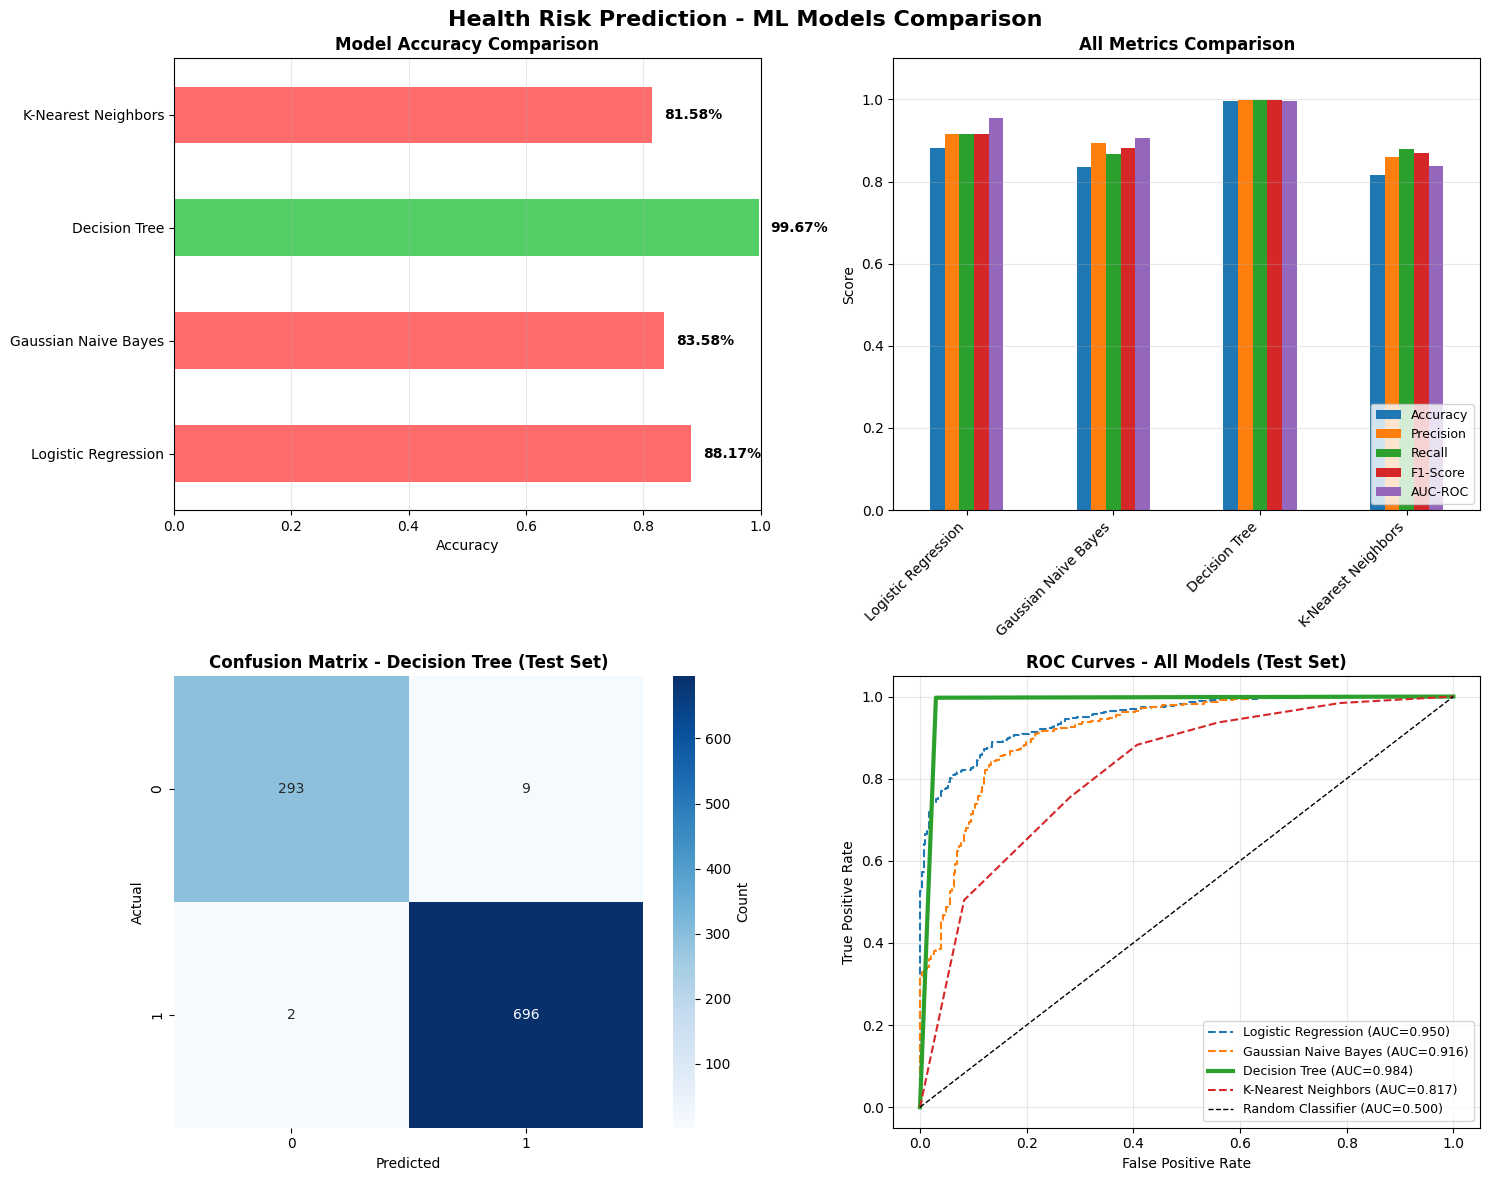

In [61]:
# ========== STEP 7: Visualizations ==========
print("\n" + "=" * 80)
print("STEP 7: Creating Visualizations")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Health Risk Prediction - ML Models Comparison', fontsize=16, fontweight='bold')

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
colors = ['#FF6B6B' if model != best_model_name else '#51CF66' 
          for model in comparison_df.index]
comparison_df['Accuracy'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
ax1.set_xlabel('Accuracy')
ax1.set_xlim([0, 1])
for i, (idx, val) in enumerate(comparison_df['Accuracy'].items()):
    ax1.text(val + 0.02, i, f'{val*100:.2f}%', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: All Metrics
ax2 = axes[0, 1]
comparison_df.plot(kind='bar', ax=ax2)
ax2.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_ylim([0, 1.1])
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Plot 3: Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0], 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name} (Test Set)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

# Plot 4: ROC Curves
ax4 = axes[1, 1]

models_dict = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

for model_name, model in models_dict.items():
    model.fit(X_train, y_train_encoded)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_proba)
    auc = roc_auc_score(y_test_encoded, y_pred_proba)
    
    line_style = '-' if model_name == best_model_name else '--'
    line_width = 3 if model_name == best_model_name else 1.5
    ax4.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})', 
            linestyle=line_style, linewidth=line_width)

ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.500)', linewidth=1)
ax4.set_title('ROC Curves - All Models (Test Set)', fontsize=12, fontweight='bold')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('health_risk_models_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'health_risk_models_comparison.png'")
plt.show()

In [62]:
# ========== STEP 8: Summary Report ==========
print("\n" + "=" * 80)
print("FINAL SUMMARY REPORT")
print("=" * 80)
# print(f"""
# 📋 PROJECT: Health Risk Prediction System
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 📊 DATA INFORMATION:
#    • Training samples: {X_train.shape[0]}
#    • Test samples: {X_test.shape[0]}
#    • Number of features: {X_train.shape[1]}
#    • Target classes: {', '.join(class_labels)}

# 🤖 MODELS TRAINED:
#    1. Logistic Regression
#    2. Gaussian Naive Bayes
#    3. Decision Tree Classifier
#    4. K-Nearest Neighbors

# 🏆 BEST PERFORMING MODEL:
#    • Model: {best_model_name}
#    • Validation Accuracy: {best_acc * 100:.2f}%
#    • Test Accuracy: {test_acc * 100:.2f}%
#    • Test AUC-ROC: {test_auc * 100:.2f}%

# 📈 MODEL RANKINGS (by Accuracy):
# """)

for i, (model, row) in enumerate(comparison_df.sort_values('Accuracy', ascending=False).iterrows(), 1):
    print(f"   {i}. {model:<30} {row['Accuracy']*100:>6.2f}%")



FINAL SUMMARY REPORT
   1. Decision Tree                   99.67%
   2. Logistic Regression             88.17%
   3. Gaussian Naive Bayes            83.58%
   4. K-Nearest Neighbors             81.58%


In [63]:
# ========== STEP 9: Model Optimization (Fine-Tuning) ==========
print("\n" + "=" * 80)
print("STEP 9: Model Optimization (Decision Tree)")
print("=" * 80)

base_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_split, y_train_split)

optimized_model = grid_search.best_estimator_
print("\n✅ Optimization Completed!")
print("Best Parameters:", grid_search.best_params_)
new_grid_search = grid_search.best_score_*100
print("Best Cross-Validation Accuracy:", '{:.2f}%'.format(new_grid_search))

acc_before = comparison_df.loc['Decision Tree', 'Accuracy']
y_pred_opt = optimized_model.predict(X_test)
acc_after = accuracy_score(y_test_encoded, y_pred_opt)
acc_before = acc_before*100
acc_after = acc_after*100

print(f"\n⚖️ Accuracy ก่อน Optimization (Validation Set): {acc_before:.2f}",'%')
print(f"🚀 Accuracy หลัง Optimization (Test Set): {acc_after:.2f}",'%')
new_data1 = (acc_after - acc_before)*100
print(f"   Improvement (Test vs Val): {new_data1:.2f}",'%')

print("\n📋 Classification Report (Optimized Model on Test Set):\n")
print(classification_report(y_test_encoded, y_pred_opt, target_names=class_labels, zero_division=0))
print("\n" + "=" * 80)



STEP 9: Model Optimization (Decision Tree)
Fitting 5 folds for each of 90 candidates, totalling 450 fits

✅ Optimization Completed!
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 99.46%

⚖️ Accuracy ก่อน Optimization (Validation Set): 99.67 %
🚀 Accuracy หลัง Optimization (Test Set): 99.70 %
   Improvement (Test vs Val): 3.33 %

📋 Classification Report (Optimized Model on Test Set):

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       302
           1       1.00      1.00      1.00       698

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


